# HOUSING PRICES WITH RIDGE REGRESSION

****************************

##### Davide Riva, Laurea Magistrale in Data Science and Economics

****************

###### I declare that this material, which I now submit for assessment, is entirely my own work and has not been taken from the work of others, save and to the extent that such work has been cited and acknowledged within the text of my work. I understand that plagiarism, collusion, and copying are grave and serious offences in the university and accept the penalties that would be imposed should I engage in plagiarism, collusion or copying. This assignment, or any part of it, has not been previously submitted by me or any other person for assessment on this or any other course of study.

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

### 1. INTRODUCTION

It is well known that Ordinary Least Squares estimation of linear regression coefficients may be exceedingly sensitive to some transformation in training data. More formally, OLS regression is not stable, a desirable property for a learning algorithm. One way to stabilize it is adding to the empirical risk minimization problem a regularization term that will shrink estimated coefficients while reducing the variance error and overfitting. Such a term, a kind of Tikhonov stabilizer that shapes Ridge regression, introduces a trade-off between stability and accuracy, as measured by MSE on the test set and by $R^{2}$ on the training set, that can be controlled by changing a regularization parameter $\alpha$. Further details about the underlying theoretical framework will be discussed in section 2.

The scope of the present analysis is to apply such a framework to a real dataset, presented in section 3, in order to check for the improvement in stability, possible underfitting, the response of the algorithm to changes in $\alpha$ and the behavior of error when introducing non-linear terms or applying dimension reduction techniques. Section 4 deals with the details, whereas conclusions are summarized in section 5.

### 2. THEORETICAL FRAMEWORK

For the whole analysis, a square loss function $l(\mathbf{w}) = (\mathbf{w^\intercal}\mathbf{x} - y)^{2}$ will be used, as it is canonical for regression. Ridge regression then solves the following minimization problem:

$\begin{equation*}
\hat{w} = argmin_{w \in R ^{d}} [\sum_{t=1}^{m} (\mathbf{w^\intercal}\mathbf{x_{t}} - y_{t})^{2} + \alpha \| \mathbf{w} \|_{2}^{2} ]
\end{equation*}$


The term with $\alpha$ is the Tikhonov stabilizer. The output of the previous minimization problem can be proved to be stable by acknowledging the fact that the square loss is both non-negative and $\beta$-smooth.

\begin{property}
$ l(\mathbf{w}) = (\mathbf{w^\intercal}\mathbf{x} - y)^{2} $ is $\beta$ -smooth
\end{property}

\begin{proof}
For the definition of $\beta$ -smoothness to hold, we need $\| \mathbf{\nabla} l(\mathbf{w}) \| ^{2} \leq 2\beta l(\mathbf{w})$

And, in the case of the square loss:

$\| \mathbf{\nabla} l(\mathbf{w}) \| ^{2} \leq 2 |\mathbf{w^\intercal}\mathbf{x} - y| ^{2} \| \mathbf{x} \| ^{2} = 2\| \mathbf{x} \| ^{2} l(\mathbf{w})$
\end{proof}

The related theorem[^1] will be stated without proof.

\begin{theorem}
Let $l(\mathbf{w})$ be non-negative and $\beta$-smooth with $\beta \leq \frac{\alpha m}{2}$, $m$ being the cardinality of the training set.

Then $\exists C$ such that empirical risk minimization with Tikhonov regularization with parameter $\alpha$ is $\frac{48\beta C}{\alpha m}$-stable.
\end{theorem}

Hence the stability of Ridge regression.

[^1]: SHALEV-SHWARTZ Shai, BEN-DAVID Shai, Understanding machine learning: from theory to algorithms, p.178, Cambridge University Press, 2014

### 3. DATA

The data were taken from the California housing dataset, which originally contained 20640 observations of 10 features about houses and their neighborhoods. The median house value within a block of houses was chosen as target (dependent) variable for the regression, whereas the explanatory variables are listed below and the first instances shown in the following table:

- longitude
- latitude
- median age of houses within a block
- number of rooms within a block
- number of bedrooms within a block
- population of the block
- number of households in the block
- median income whithin a block
- area (near bay, near ocean, in an hour from the ocean, inland, island)


In [86]:
dataset = pd.read_csv("cal-housing.csv")
dataset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Plotting a map of instances and the distribution of the target variable, some preliminary observations may be proposed. First of all, houses in the inland generally have lower values than those in other areas, suggesting the ocean proximity categorical variable to be significant, with a negative coefficient for the inland and positive one for the bay. From this characteristic, also the significance of the longitude feature may be derived, since, other things equal, westernmost houses tend to be more expensive. The same for latitude, with southernmost blocks presenting higher median values.

As for the distribution of the target variable, an odd asymmetry arises. Apart from a little leftward imbalance, a lot of instances unexplainably take a value around 500000. I suggest two plausible reasons for this behavior: first, data might have been stored improperly, repeating a single entry multiple times; second, values that exceeded the 500000 threshold might have been pushed downward as, for example, in Tillé and Langel's approach for income inequality evaluation[^2]. Due to this last consideration, as well as to the amount of information they contain (around 5%), such data should not be removed from the analysis. However, their presence contributes much to the imbalance of median house value distribution, and, based on the sensible idea that those instances are part of a totally different market (luxury housing market), I decided to exclude them.

[^2]: CHEUNG L.C., GASTWIRTH J.L., LYON M. (2015), “The Advantages of Using Group Means in Estimating the Lorenz Curve and Gini Index from Grouped Data”, The American Statistician, DOI: 10.1080/00031305.2015.1105152

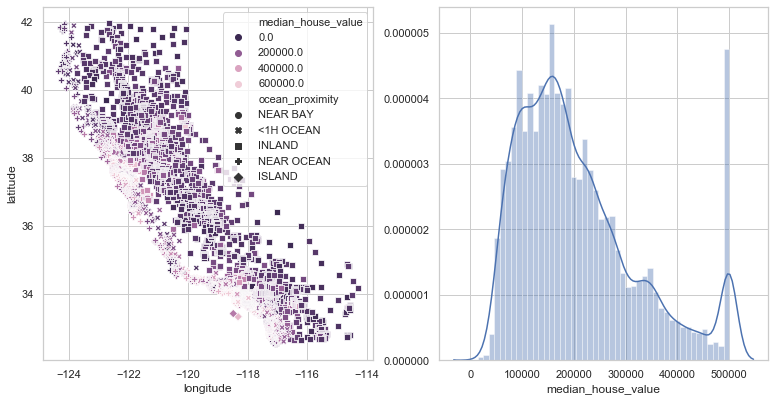

In [87]:
sb.set(style="whitegrid")
f, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13,6.5))
sb.scatterplot(x="longitude", y="latitude",
                hue="median_house_value", style="ocean_proximity",
                palette="ch:r=.3,d=.2_r", 
                data=dataset, legend = "brief", ax = ax1)
sb.distplot(dataset['median_house_value'], ax = ax2)

In [88]:
#exclude luxury house market
dataset = dataset.loc[dataset.median_house_value < 500000]

In [89]:
#standardize numeric variables

for j in dataset.columns:
    if isinstance(dataset.loc[0,j], (float, int)):
        dataset[j] = (dataset[j] - dataset[j].mean())/dataset[j].std()

In [90]:
dummies = pd.get_dummies(dataset.ocean_proximity)
ocean_prox = dataset.pop('ocean_proximity')

dataset = pd.merge(dataset, dummies, left_index=True, right_index=True)

In [92]:
data = dataset.copy(deep=True)

### 4. ANALYSIS

Numeric variables were first standardized, since OLS regression is scale-invariant but Ridge regression is not, and the presence of multicollinearity issues was checked. The correlation matrix clearly highlights the collinearity between longitude and latitude (due to the peculiar shape of California territory), as well as among the number of rooms, bedrooms, inhabitants and households. Since the bedrooms feature was the only one that included some null values, although amounting to less than 1% of instances, it was directly removed, whereas Variance Inflation Factors were computed for the others. The highest VIF, except for dummies, was found for the number of households, which was then excluded from the regression framework just like the number of bedrooms.

In [93]:
y = data.median_house_value
island = data.pop('ISLAND')
data = data.drop(columns = ['median_house_value'])
C = data.drop(columns = ['<1H OCEAN', 'INLAND', 'NEAR BAY', 'NEAR OCEAN']).cov()

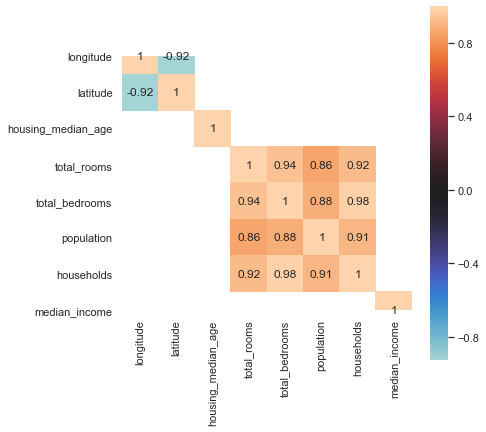

In [94]:
f, ax = plt.subplots(figsize=(6.5,6.5))
sb.heatmap(C, center = 0, annot=True, square = True, mask = C.abs()<0.8, ax=ax)

In [95]:
data = data.drop(columns = 'total_bedrooms')

In [96]:
#define a function that computes VIFs
#X must be a Pandas data frame

def VIF(X):
    X = (X - X.mean(axis=0))/X.std(axis=0)
    vif = []
    for j in X.columns:
        yj = np.array(X[j])
        Xj = np.matrix(X.drop(columns = [j]))
        beta = np.linalg.inv(Xj.T @ Xj) @ Xj.T @ yj
        residuals = yj - Xj @ np.reshape(np.asarray(beta), newshape=-1)
        RSS = np.square(residuals).sum()
        vif.append(np.var(yj, ddof = len(yj)-1)/RSS)
        
    vif = pd.Series(vif, index = X.columns)
    return vif

In [97]:
data = data.drop(columns = 'households')

It is now possible to turn to the analysis of the stability-accuracy tradeoff. In this context, cross-validation is useful to define both the error and its variance, whereas the coefficient standard errors were computed using the formula $Var[\hat{\mathbf{w}}] = Var[(X^\intercal X + \alpha I)^{-1}X^\intercal \mathbf{\epsilon}]$, where $\epsilon$ are assumed to be homoskedastic and uncorrelated residuals. In order to evaluate accuracy, $R^{2}$ is computed on the training set and MSE on the test set. The results are then averaged across folds and their empirical variances are used as proxies to address stability, together with coefficient standard errors. 

One aspect that is worth noticing in this approach is that increasing the number of folds K reduces $R^{2}$ variance, because training folds overlap more, but it also increases MSE variance. The graphs below can be considered on a par with learning curves, as increasing the number of folds corresponds to enlarging the training set. In this case, the training accuracy falls slightly (in the order of $10^{-4}$) and so does its standard deviation, as just stated. On the other hand, the MSE stays almost constant and its deviation clearly increases. From this first representation, the linear model (here with OLS estimation of coefficients) seems to suffer from underfitting.

In order to have means and variances almost stabilized, the following analysis will use an intermediate number of folds, in particular K=10.

In [98]:
#define a function that computes K-fold CV MSE for a Ridge regression model on data X and target variable y
#X must be a Pandas data frame, y a Pandas series, K an integer and alpha a real number

def ridge_cv(K, alpha, X, y):
    
    y.index = X.index
    p = X.shape[1]
    
    #create a series with values randomly extracted from U{0,...,K-1} and indices equal to row indices of data
    folds = np.random.randint(low = 0, high = K, size = y.shape)
    folds = pd.Series(folds, index = y.index)
    
    #initialize lists for regression coefficients, standard errors, MSE, R2 and observations per fold
    coef = []
    stderr = []
    MSE = []
    R2 = []
    nk = []
    
    #for cycle --> training on K-1 folds and testing on the remaining 1
    for k in range(K):
        X_train = np.matrix(X.loc[folds != k, :])
        y_train = np.array(y.loc[folds != k])
        X_test = np.matrix(X.loc[folds == k, :])
        y_test = np.array(y.loc[folds == k])
        nk.append(X_test.shape[0])
        
        # w = (X'X + aI)^(-1)*X'y  on the training set
        XX = X_train.T @ X_train + np.diag(np.full(shape = p, fill_value = alpha))
        beta = np.linalg.inv(XX) @ X_train.T @ y_train
        beta = np.reshape(np.asarray(beta), newshape=-1)
        coef.append(beta)
        
        # R2 = 1 - RSS/TSS
        residuals = y_train - X_train @ beta
        RSS = np.square(residuals).sum()
        TSS = np.var(y_train, ddof = len(y_train)-1)
        R2.append(1 - RSS/TSS)
        
        # SE = (X'X + aI)^(-1)*X'*Var(y)*X*(X'X + aI)^(-1)  assuming homoskedasticity and uncorrelated residuals
        var_beta = np.var(residuals) * np.diag(np.linalg.inv(XX) @ X_train.T @ X_train @ np.linalg.inv(XX))
        stderr.append(np.sqrt(var_beta))
        
        # MSE = (1/n)*||Xw - y||^2  on the test set
        msqerr = np.mean(np.square(y_test - X_test @ beta))
        MSE.append(msqerr)
        
        
    #transform lists into matrices and arrays to make operations on them
    coef = np.array(coef)
    stderr = np.array(stderr)
    MSE = np.array(MSE)
    R2 = np.array(R2)
    nk = np.array(nk)
    
    #take the weighted averages and the variances
    w = np.average(coef, axis = 0, weights = nk)
    w = pd.Series(w, index = X.columns)
    
    SE = np.average(stderr, axis = 0, weights = nk)
    SE = pd.Series(SE, index = X.columns)
    
    mean_MSE = np.average(MSE, weights = nk)
    
    MSE_var = np.average(np.square(MSE - mean_MSE), weights = nk)
    
    mean_R2 = np.average(R2, weights = nk)
    
    R2_var = np.average(np.square(R2 - mean_R2), weights = nk)
    
    return w, SE, mean_MSE, MSE_var, mean_R2, R2_var

In [99]:
run = range(3,21)
MSE_mean_K = np.array([ridge_cv(K=k, alpha=0, X=data, y=y)[2] for k in run])
R2_mean_K = np.array([ridge_cv(K=k, alpha=0, X=data, y=y)[4] for k in run])
MSE_var_K = np.array([ridge_cv(K=k, alpha=0, X=data, y=y)[3] for k in run])
R2_var_K = np.array([ridge_cv(K=k, alpha=0, X=data, y=y)[5] for k in run])

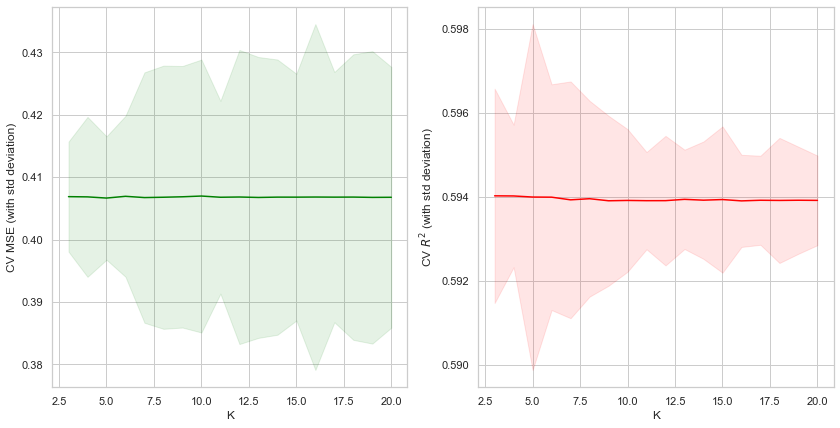

In [100]:
f, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(14,7))

ax1.plot(run, MSE_mean_K, color="green")
ax1.fill_between(run, MSE_mean_K - np.sqrt(MSE_var_K), MSE_mean_K + np.sqrt(MSE_var_K), alpha=0.1, color="green")
ax1.set_xlabel("K")
ax1.set_ylabel("CV MSE (with std deviation)")

ax2.plot(run, R2_mean_K, color="red")
ax2.fill_between(run, R2_mean_K - np.sqrt(R2_var_K), R2_mean_K + np.sqrt(R2_var_K), alpha=0.1, color="red")
ax2.set_xlabel("K")
ax2.set_ylabel("CV " + r"$R^{2}$" + " (with std deviation)")

plt.show()

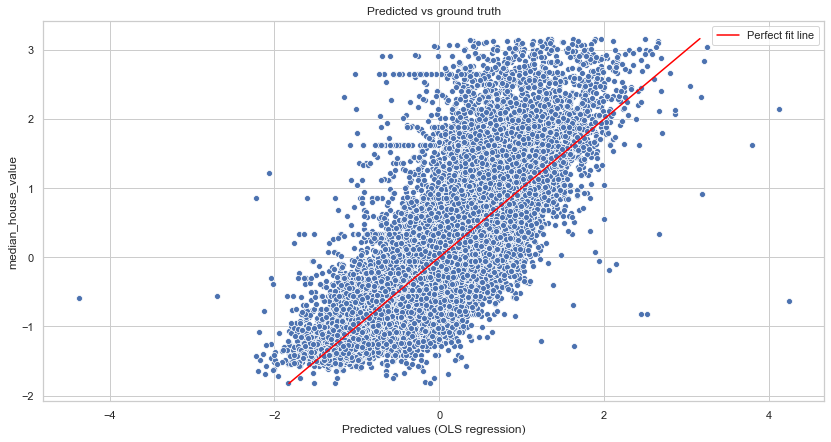

In [101]:
w, SE, mean_MSE, MSE_var, mean_R2, R2_var = ridge_cv(K=10, alpha=0, X = data, y = y)
sb.set(style="whitegrid")
f, ax1 = plt.subplots(figsize=(14,7))

sb.scatterplot(x = data @ w, y = y, ax = ax1)
t = np.linspace(min(y.values), max(y.values), num = 1000)
pft_line, = ax1.plot(t, t, color = 'red')
pft_line.set_label("Perfect fit line")
ax1.set_xlabel("Predicted values (OLS regression)")
ax1.set_title("Predicted vs ground truth")
ax1.legend()

plt.show()

The time has come to introduce Tikhonov regularization and examine the behavior of errors and their variances.

As expected, greater $\alpha$ produce lower accuracy on the training set, because regression coefficients are shrinked, and also higher test error. What was instead expected for the error deviation as a consequence of stabilization did not realize, at least in a range of $\alpha$ from 0 to 500. One possible interpretation for this undesirable result is that the linear model may underfit. In fact, the $R^{2}$ coefficient never reaches 60%. In any case, Ridge regression doesn't bring any improvement from this perspective. Other models may be tried, for instance:

- interaction terms may be included to account for differences among areas;
- any dimension reduction technique may be applied prior to regression;
- nonlinear transformations of features may be added to the model, if data suggest such relationships.


In [102]:
#plot CV MSE against alpha
alpha_run = range(501)
w = [ridge_cv(K=10, alpha = a, X = data, y = y)[0] for a in alpha_run]
w_se = [ridge_cv(K=10, alpha = a, X = data, y = y)[1] for a in alpha_run]
MSE_mean_alpha = [ridge_cv(K=10, alpha = a, X = data, y = y)[2] for a in alpha_run]
MSE_var_alpha = [ridge_cv(K=10, alpha = a, X = data, y = y)[3] for a in alpha_run]
R2_mean_alpha = [ridge_cv(K=10, alpha = a, X = data, y = y)[4] for a in alpha_run]
R2_var_alpha = [ridge_cv(K=10, alpha = a, X = data, y = y)[5] for a in alpha_run]

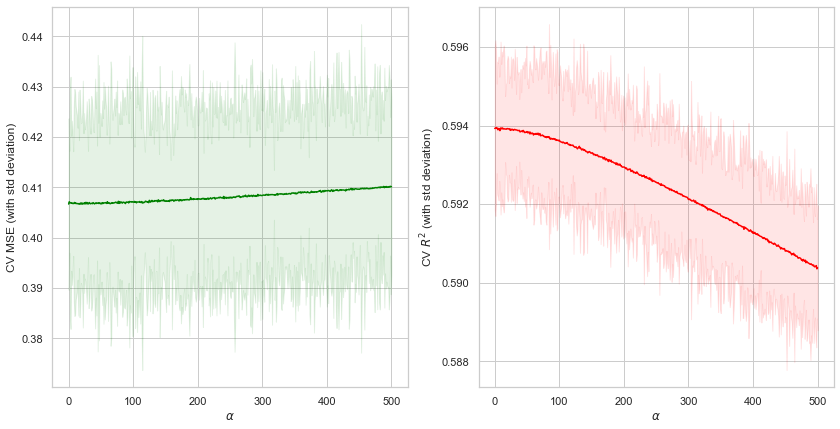

In [103]:
f, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(14,7))

ax1.plot(alpha_run, MSE_mean_alpha, color="green")
ax1.fill_between(alpha_run, MSE_mean_alpha - np.sqrt(MSE_var_alpha), MSE_mean_alpha + np.sqrt(MSE_var_alpha), alpha=0.1, color="green")
ax1.set_xlabel(r"$\alpha$")
ax1.set_ylabel("CV MSE (with std deviation)")

ax2.plot(alpha_run, R2_mean_alpha, color="red")
ax2.fill_between(alpha_run, R2_mean_alpha - np.sqrt(R2_var_alpha), R2_mean_alpha + np.sqrt(R2_var_alpha), alpha=0.1, color="red")
ax2.set_xlabel(r"$\alpha$")
ax2.set_ylabel("CV " + r"$R^{2}$" + " (with std deviation)")

plt.show()

As for the coefficient behavior, it is plain to see that median income plays the bigger (positive) role and is not affected by regularization, whereas houses in the inland are generally less valuable. All in all, regression coefficients look unaffected (or, at most, slightly affected) by the choice of $\alpha$ and their interpretation remains always the same. Their 95% confidence intervals are also unaffected (at least most of them), besides being generally thin even for low values of $\alpha$. This fact reinforces the thesis according to which the Ridge regression doesn't bring any substantial improvement in stability while reducing accuracy.

Text(0, 0.5, 'Regression coefficients')

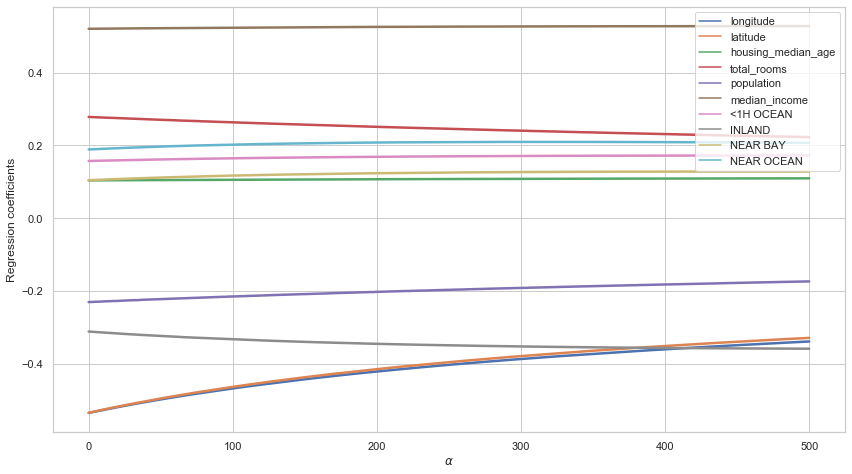

In [104]:
sb.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12,6.75), tight_layout=True)
sb.lineplot(data=pd.DataFrame(w), style=np.arange(len(w)), dashes=False, linewidth=2.5)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel("Regression coefficients")

In [105]:
w = pd.DataFrame(w)
w_se = pd.DataFrame(w_se)

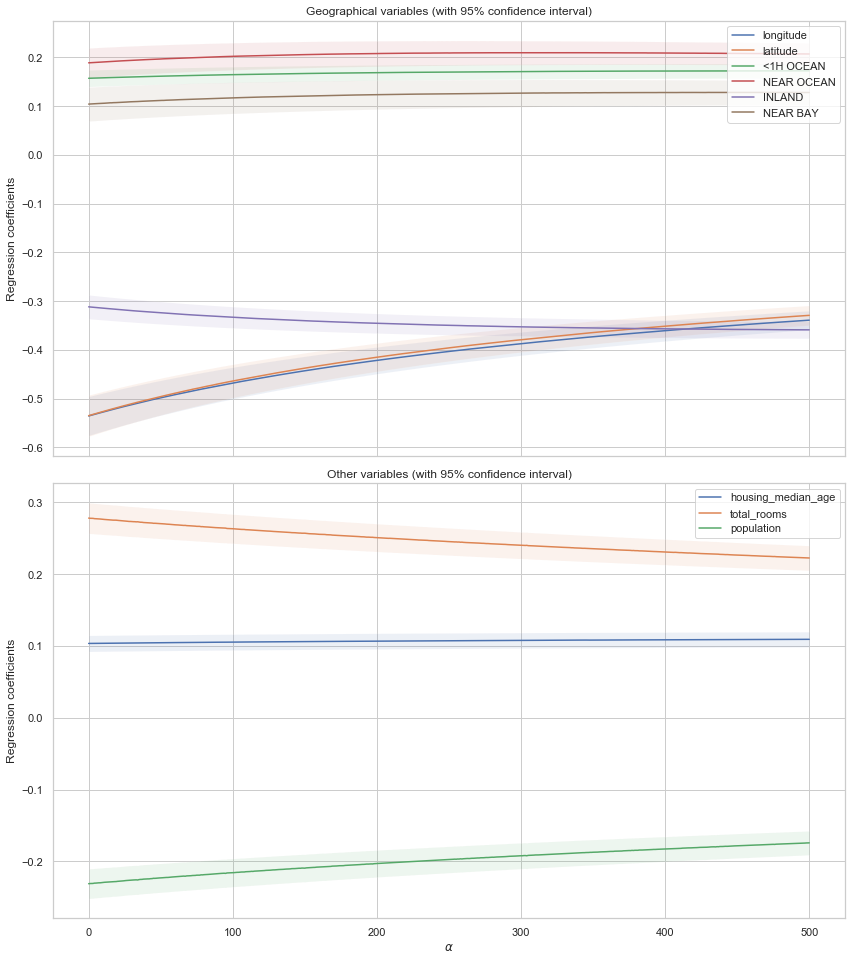

In [106]:
P, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 13.5), tight_layout=True)
ax1.plot('longitude',data=w)
ax1.fill_between(alpha_run, w.longitude-2*w_se.longitude, w.longitude+2*w_se.longitude, alpha=0.1)
ax1.plot('latitude',data=w)
ax1.fill_between(alpha_run, w.latitude-2*w_se.latitude, w.latitude+2*w_se.latitude, alpha=0.1)
ax1.plot('<1H OCEAN',data=w)
ax1.fill_between(alpha_run, w['<1H OCEAN']-2*w_se['<1H OCEAN'], w['<1H OCEAN']+2*w_se['<1H OCEAN'], alpha=0.1)
ax1.plot('NEAR OCEAN',data=w)
ax1.fill_between(alpha_run, w['NEAR OCEAN']-2*w_se['NEAR OCEAN'], w['NEAR OCEAN']+2*w_se['NEAR OCEAN'], alpha=0.1)
ax1.plot('INLAND',data=w)
ax1.fill_between(alpha_run, w['INLAND']-2*w_se['INLAND'], w['INLAND']+2*w_se['INLAND'], alpha=0.1)
ax1.plot('NEAR BAY',data=w)
ax1.fill_between(alpha_run, w['NEAR BAY']-2*w_se['NEAR BAY'], w['NEAR BAY']+2*w_se['NEAR BAY'], alpha=0.1)

ax2.plot('housing_median_age',data=w)
ax2.fill_between(alpha_run, w.housing_median_age-2*w_se.housing_median_age, w.housing_median_age+2*w_se.housing_median_age, alpha=0.1)
ax2.plot('total_rooms',data=w)
ax2.fill_between(alpha_run, w.total_rooms-2*w_se.total_rooms, w.total_rooms+2*w_se.total_rooms, alpha=0.1)
ax2.plot('population',data=w)
ax2.fill_between(alpha_run, w.population-2*w_se.population, w.population+2*w_se.population, alpha=0.1)

ax2.set_xlabel(r"$\alpha$")
ax1.set_ylabel("Regression coefficients")
ax2.set_ylabel("Regression coefficients")
ax1.set_title("Geographical variables (with 95% confidence interval)")
ax2.set_title("Other variables (with 95% confidence interval)")
ax1.legend(loc=1)
ax2.legend(loc=1)
plt.show()

The previously outlined strategies can be implemented to look for any change, hopefully an improvement.

The first one deals with interaction terms, which, however, would be 24. To simplify the analysis, the 4 subsets of observations can be separated (the fifth, containing houses on an island, is too small for a regression, which would certainly overfit due to the dominance of the number of variables over the numerosity of the sample). Doing so, similar results for 3 out of 4 subsets are found. The only one that differs refers to houses in proximity of the bay, for which latitude, longitude and the number of rooms seem to count more. This is no longer true if $\alpha$ exceeds a threshold slightly above 50. In the other areas the coefficients reflect the state-level behavior, thus making the inclusion of regression terms less interesting.

In [107]:
#application to geographical subgroups (except for ISLAND)
w_inland = [ridge_cv(K=10, alpha=a, X = data.loc[data["INLAND"]==1, "longitude":"median_income"], y = y.loc[data["INLAND"]==1])[0] for a in alpha_run]
w_inland = pd.DataFrame(w_inland)

w_nearbay = [ridge_cv(K=10, alpha=a, X = data.loc[data["NEAR BAY"]==1, "longitude":"median_income"], y = y.loc[data["NEAR BAY"]==1])[0] for a in alpha_run]
w_nearbay = pd.DataFrame(w_nearbay)

w_nearocean = [ridge_cv(K=10, alpha=a, X = data.loc[data["NEAR OCEAN"]==1, "longitude":"median_income"], y = y.loc[data["NEAR OCEAN"]==1])[0] for a in alpha_run]
w_nearocean = pd.DataFrame(w_nearocean)

w_1hour = [ridge_cv(K=10, alpha=a, X = data.loc[data["<1H OCEAN"]==1, "longitude":"median_income"], y = y.loc[data["<1H OCEAN"]==1])[0] for a in alpha_run]
w_1hour = pd.DataFrame(w_1hour)


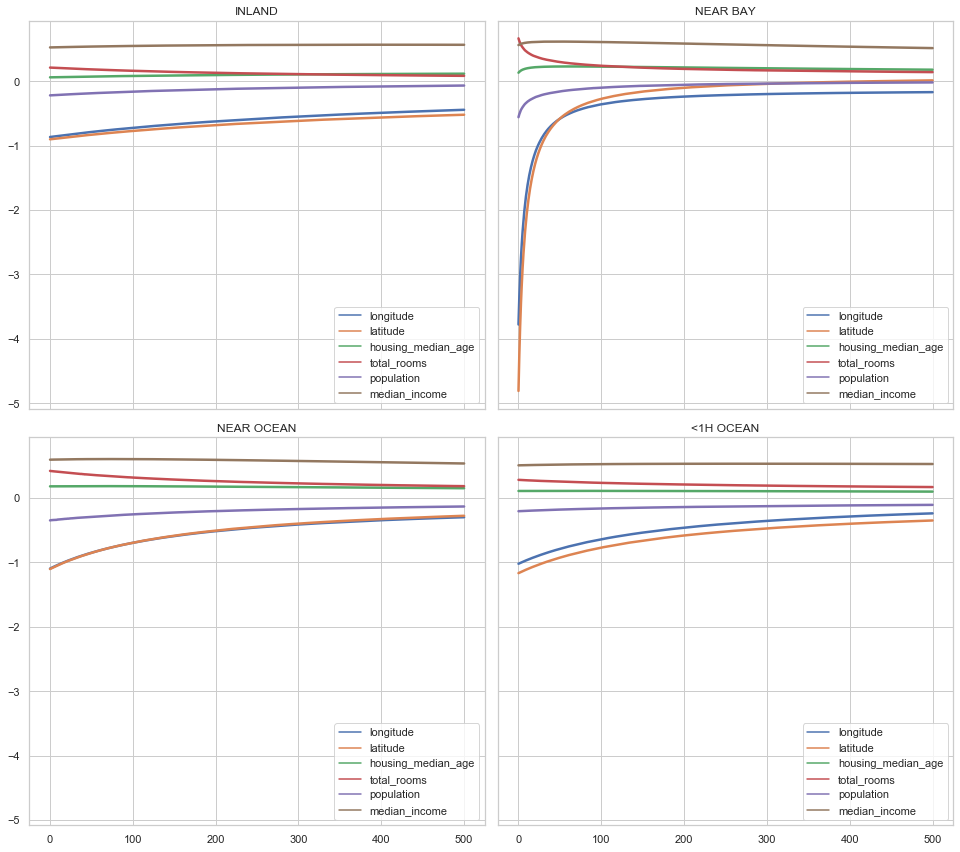

In [108]:
fig, ((p1,p2),(p3,p4)) = plt.subplots(nrows=2,ncols=2, figsize=(13.5,12), tight_layout=True, sharex="all", sharey="all")
sb.lineplot(data=w_inland, style=np.arange(12), dashes=False, linewidth=2.5, ax=p1)
p1.set_title("INLAND")
p1.legend(loc=4)
sb.lineplot(data=w_nearbay, style=np.arange(12), dashes=False, linewidth=2.5, ax=p2)
p2.set_title("NEAR BAY")
p2.legend(loc=4)
sb.lineplot(data=w_nearocean, style=np.arange(12), dashes=False, linewidth=2.5, ax=p3)
p3.set_title("NEAR OCEAN")
p3.legend(loc=4)
sb.lineplot(data=w_1hour, style=np.arange(12), dashes=False, linewidth=2.5, ax=p4)
p4.set_title("<1H OCEAN")
p4.legend(loc=4)
plt.show()

The second strategy involves dimension reduction and is the one that deserves the deepest discussion.

Since the dataset contains both qualitative and quantitative variables, Principal Component Analysis is not appropriate by itself, unless the only categorical feature was considered as supplementary. Leaving this alternative approach for later, I start by applying Factor Analysis of Mixed Data, a particular technique that combines PCA with Multiple Correspondence Analysis. 

As in PCA, the principal directions explain some proportion of variance. The cumulative screeplot in figure is a simple representation of its growth when new directions are added. It can be noticed that the total PVE of the first 2 principal components is less than 50%, meaning that these directions are generally inappropriate to explain the distribution of data by themselves. At least 5 components would indeed be needed to reach 80% of variance explained.

In [109]:
data = pd.merge(data, island, left_index=True, right_index=True)

In [110]:
for col in data.loc[:, '<1H OCEAN':'NEAR OCEAN'].columns:
    data[col] = data[col] / data[col].sum()
    data[col] = (data[col] - data[col].mean()) / data[col].std()


In [111]:
C = data.T @ data
lamb, V = np.linalg.eig(C.values)

Text(0.5, 1.0, 'FAMD cumulative PVE')

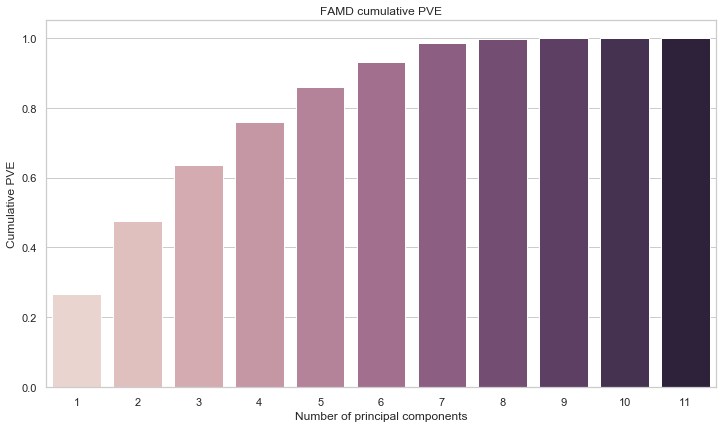

In [112]:
#cumulative screeplot
sb.set(style="whitegrid")
f, ax = plt.subplots(figsize=(12,6.75))
t = np.arange(1, len(lamb)+1)
sb.barplot(x=t, y=np.cumsum(lamb)/np.sum(lamb), palette=sb.cubehelix_palette(len(lamb)))
ax.set_xlabel("Number of principal components")
ax.set_ylabel("Cumulative PVE")
ax.set_title("FAMD cumulative PVE")

Despite being poor in explained variance, the first 2 principal directions are easily interpretable: the first one is almost purely geographical, longitude and local dummies having the highest loadings; the second one, instead, mainly represents population (together with rooms) and housing age, so that it is possible to think about a dichotomy between new blocks of large houses and old blocks of small ones. Curiously, median income, the most relevant variable in previous models, has low correlation with both directions, thus suggesting that dimension reduction won't yield better results.

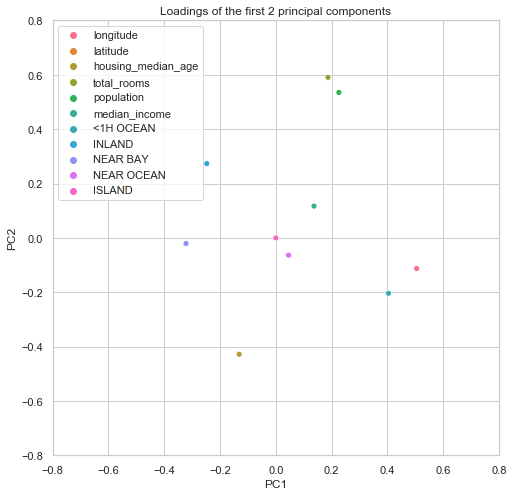

In [113]:
#loadings of the first 2 principal components
two_pc = V[:,:2]
sb.set(style="whitegrid")
f, ax = plt.subplots(figsize=(8,8))
sb.scatterplot(x = two_pc[:,0], y = two_pc[:,1], hue = data.columns, ax=ax)
ax.legend(loc=2)
ax.set_title("Loadings of the first 2 principal components")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_xlim(-0.8, 0.8)
ax.set_ylim(-0.8, 0.8)
plt.show()

Quite the opposite, a clear worsening is visible. The average MSE rises from 0.4 to 0.95, and the $R^{2}$ deteriorates from 59% to less than 6%. The graph below, which shows a comparison between predicted and empirical values, highlights the concentration of predictions (somewhat towards low values), perhaps due to the aforementioned almost total absence of the most relevant feature from the regression, which positively affected predictions.

In [114]:
#scores and CV for the Ridge 
scores = pd.DataFrame(data.values @ two_pc)
FAMD_MSE_mean_alpha = [ridge_cv(K=10, alpha = a, X = scores, y = y)[2] for a in alpha_run]
FAMD_MSE_var_alpha = [ridge_cv(K=10, alpha = a, X = scores, y = y)[3] for a in alpha_run]
FAMD_R2_mean_alpha = [ridge_cv(K=10, alpha = a, X = scores, y = y)[4] for a in alpha_run]
FAMD_R2_var_alpha = [ridge_cv(K=10, alpha = a, X = scores, y = y)[5] for a in alpha_run]

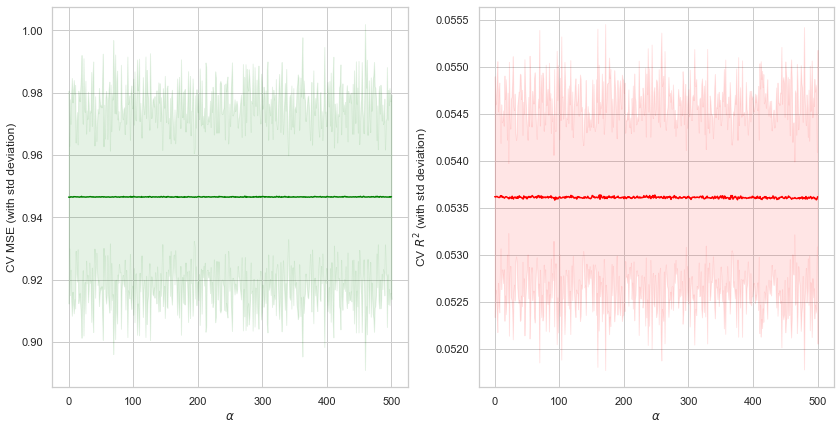

In [115]:
f, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(14,7))

ax1.plot(alpha_run, FAMD_MSE_mean_alpha, color="green")
ax1.fill_between(alpha_run, FAMD_MSE_mean_alpha - np.sqrt(FAMD_MSE_var_alpha), FAMD_MSE_mean_alpha + np.sqrt(FAMD_MSE_var_alpha), alpha=0.1, color="green")
ax1.set_xlabel(r"$\alpha$")
ax1.set_ylabel("CV MSE (with std deviation)")

ax2.plot(alpha_run, FAMD_R2_mean_alpha, color="red")
ax2.fill_between(alpha_run, FAMD_R2_mean_alpha - np.sqrt(FAMD_R2_var_alpha), FAMD_R2_mean_alpha + np.sqrt(FAMD_R2_var_alpha), alpha=0.1, color="red")
ax2.set_xlabel(r"$\alpha$")
ax2.set_ylabel("CV " + r"$R^{2}$" + " (with std deviation)")

plt.show()

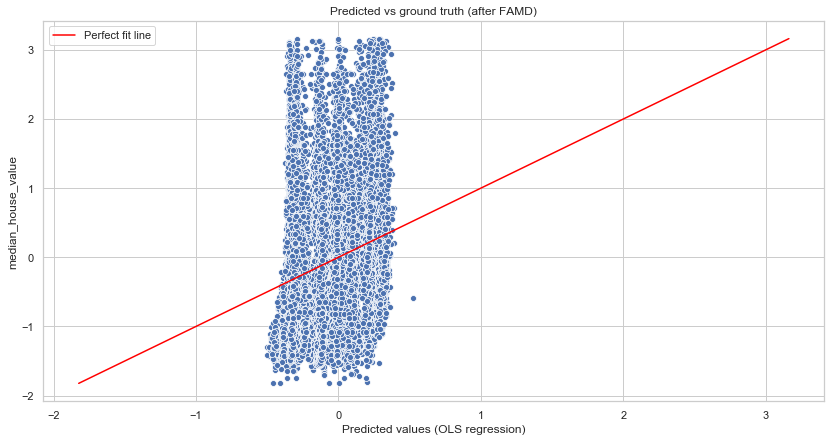

In [116]:
w, SE, mean_MSE, MSE_var, mean_R2, R2_var = ridge_cv(K=10, alpha=0, X = scores, y = y)
sb.set(style="whitegrid")
f, ax1 = plt.subplots(figsize=(14,7))

sb.scatterplot(x = scores @ w, y = y, ax = ax1)
t = np.linspace(min(y.values), max(y.values), num = 1000)
pft_line, = ax1.plot(t, t, color = 'red')
pft_line.set_label("Perfect fit line")
ax1.set_xlabel("Predicted values (OLS regression)")
ax1.set_title("Predicted vs ground truth (after FAMD)")
ax1.legend()

plt.show()

Although dimension reduction yields poor results, an alternative approach is also tried. Here the categorical variable is considered as supplementary, whereas quantitative features are the only active ones. If the scores obtained throught PCA were clearly separable into the 5 geographical areas, then the categories may be explainable in terms of the other variables and PCA may therefore be the correct approach. In particular, principal directions would have higher PVEs, thus improving their representativity of data.

The graphs below show that the cumulative PVE of the 2 principal components indeed rises from less than 50% to almost 70%, although the third component is needed to reach 80%. Nevertheless, the scatterplot denies the possibility to clearly split data points into clusters, so FAMD on all variables may be preferable to PCA applied only to numeric ones.

In [117]:
#last try: consider qualitative variable as supplementary
C_supp = data.loc[:,'longitude':'median_income'].cov()
new_lamb, new_V = np.linalg.eig(C_supp)
indices = np.argsort(new_lamb)
new_lamb = np.sort(new_lamb)[::-1]
new_V = np.array([new_V[i] for i in indices[::-1]])

Text(0.5, 1.0, 'PCA cumulative PVE')

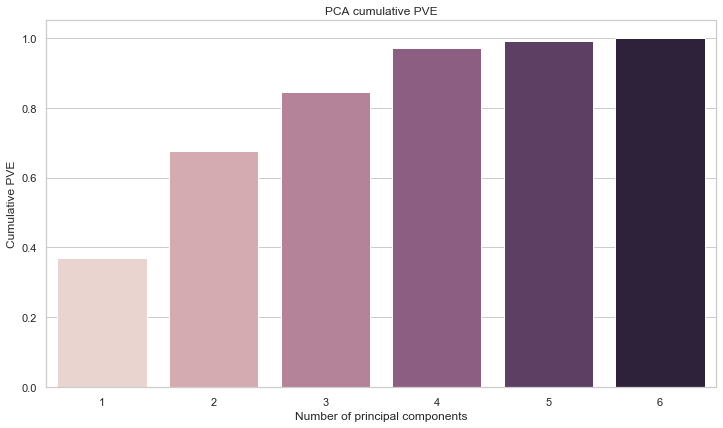

In [118]:
#cumulative screeplot
sb.set(style="whitegrid")
f, ax = plt.subplots(figsize=(12,6.75))
t = np.arange(1, len(new_lamb)+1)
sb.barplot(x=t, y=np.cumsum(new_lamb)/np.sum(new_lamb), palette=sb.cubehelix_palette(len(new_lamb)))
ax.set_xlabel("Number of principal components")
ax.set_ylabel("Cumulative PVE")
ax.set_title("PCA cumulative PVE")

In [119]:
new_two_pc = new_V[:,:2]
new_scores = pd.DataFrame(data.loc[:,'longitude':'median_income'].values @ new_two_pc)

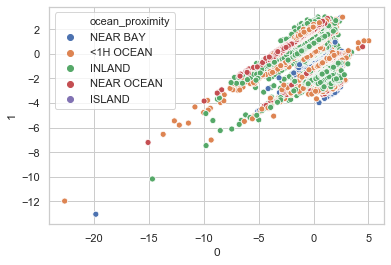

In [120]:
sb.set(style="whitegrid")
sb.scatterplot(x = new_scores.iloc[:,0], y = new_scores.iloc[:,1], hue = ocean_prox)

So far we've seen that neither geographical subsamples nor dimension reduction (in particular from FAMD, which was judged as the most appropriate approach) can help improve the model.

One last try involves a quick look at pairwise relationships between the target variable and numeric explanatory ones. Scatterplots are useful in this sense. More precisely, we're interested in acknowledging whether there may be non-linear relationships, so that the inclusion of specific non-linear terms in the regression may improve accuracy, but, as displayed in the plots, only few relationships look worth verifying (for instance the one with median income seems to have a quadratic profile).

In [121]:
w, SE, mean_MSE, MSE_var, mean_r2, R2_var = ridge_cv(K = 10, alpha = 0, X = data.drop(columns = 'ISLAND'), y = y)

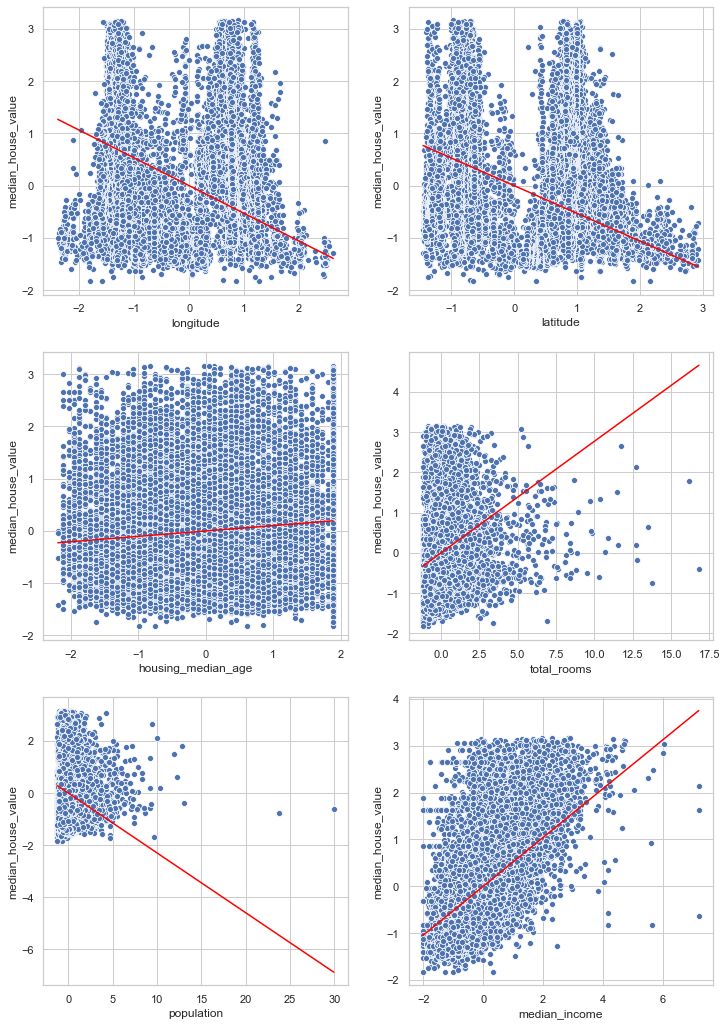

In [122]:
f, ((p1,p2), (p3,p4), (p5,p6)) = plt.subplots(nrows = 3, ncols = 2, figsize = (12,18))

sb.scatterplot(x = data['longitude'], y = y, ax = p1)
t = np.linspace(min(data.longitude.values), max(data.longitude.values), num = 1000)
p1.plot(t, w.longitude * t, color = 'red')

sb.scatterplot(x = data['latitude'], y = y, ax = p2)
t = np.linspace(min(data.latitude.values), max(data.latitude.values), num = 1000)
p2.plot(t, w.latitude * t, color = 'red')

sb.scatterplot(x = data['housing_median_age'], y = y, ax = p3)
t = np.linspace(min(data.housing_median_age.values), max(data.housing_median_age.values), num = 1000)
p3.plot(t, w.housing_median_age * t, color = 'red')

sb.scatterplot(x = data['total_rooms'], y = y, ax = p4)
t = np.linspace(min(data.total_rooms.values), max(data.total_rooms.values), num = 1000)
p4.plot(t, w.total_rooms * t, color = 'red')

sb.scatterplot(x = data['population'], y = y, ax = p5)
t = np.linspace(min(data.population.values), max(data.population.values), num = 1000)
p5.plot(t, w.population * t, color = 'red')

sb.scatterplot(x = data['median_income'], y = y, ax = p6)
t = np.linspace(min(data.median_income.values), max(data.median_income.values), num = 1000)
p6.plot(t, w.median_income * t, color = 'red')

plt.show()

Quadratic terms of all features are then included in the model in order to verify which among them will be significant and how their inclusion will affect accuracy. Actually there is little improvement in average MSE and $R^{2}$ (less than 0.01 for each), but, except for latitude when the Ridge is close to OLS regression, all quadratic coefficients are significant at a 5% level. Moreover, the CV MSE has decreasing variance, an effect that may be attributed to the theoretically lower variance of the model.

In [123]:
data = data.drop(columns = 'ISLAND')

In [124]:
sqdata = data.loc[:,'longitude':'median_income'].pow(2)
newdata = pd.merge(data, sqdata, left_index = True, right_index = True)

In [125]:
MSE_mean_alpha = [ridge_cv(K=10, alpha = a, X = newdata, y = y)[2] for a in alpha_run]
MSE_var_alpha = [ridge_cv(K=10, alpha = a, X = newdata, y = y)[3] for a in alpha_run]
R2_mean_alpha = [ridge_cv(K=10, alpha = a, X = newdata, y = y)[4] for a in alpha_run]
R2_var_alpha = [ridge_cv(K=10, alpha = a, X = newdata, y = y)[5] for a in alpha_run]

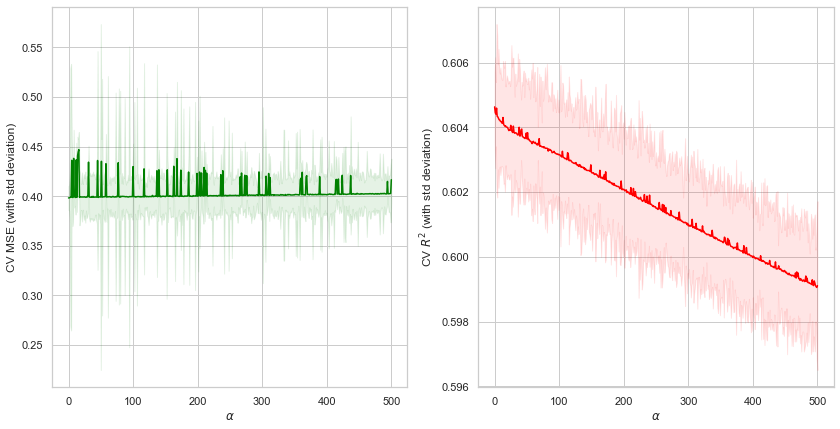

In [126]:
f, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(14,7))

ax1.plot(alpha_run, MSE_mean_alpha, color="green")
ax1.fill_between(alpha_run, MSE_mean_alpha - np.sqrt(MSE_var_alpha), MSE_mean_alpha + np.sqrt(MSE_var_alpha), alpha=0.1, color="green")
ax1.set_xlabel(r"$\alpha$")
ax1.set_ylabel("CV MSE (with std deviation)")

ax2.plot(alpha_run, R2_mean_alpha, color="red")
ax2.fill_between(alpha_run, R2_mean_alpha - np.sqrt(R2_var_alpha), R2_mean_alpha + np.sqrt(R2_var_alpha), alpha=0.1, color="red")
ax2.set_xlabel(r"$\alpha$")
ax2.set_ylabel("CV " + r"$R^{2}$" + " (with std deviation)")

plt.show()

In [127]:
w = pd.DataFrame([ridge_cv(K=10, alpha = a, X = newdata, y = y)[0] for a in alpha_run])
w_se = pd.DataFrame([ridge_cv(K=10, alpha = a, X = newdata, y = y)[1] for a in alpha_run])

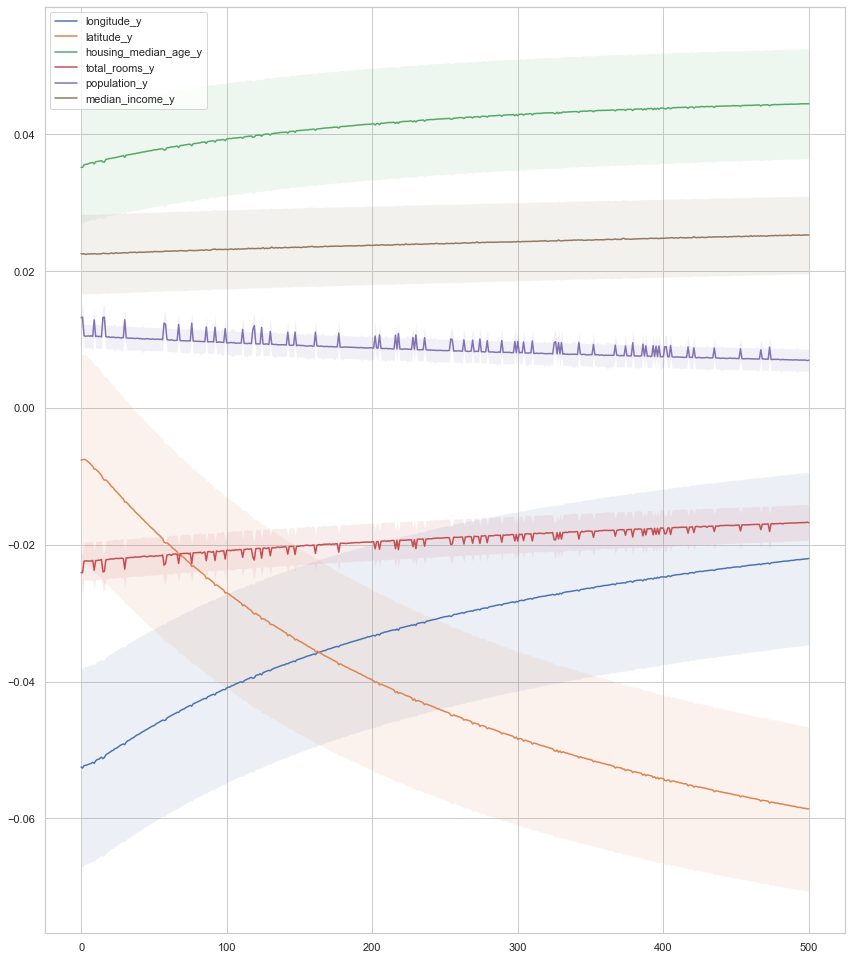

In [128]:
P, ax = plt.subplots(figsize=(12, 13.5), tight_layout=True)
ax.plot('longitude_y',data=w)
ax.fill_between(alpha_run, w.longitude_y-2*w_se.longitude_y, w.longitude_y+2*w_se.longitude_y, alpha=0.1)
ax.plot('latitude_y',data=w)
ax.fill_between(alpha_run, w.latitude_y-2*w_se.latitude_y, w.latitude_y+2*w_se.latitude_y, alpha=0.1)
ax.plot('housing_median_age_y',data=w)
ax.fill_between(alpha_run, w.housing_median_age_y-2*w_se.housing_median_age_y, w.housing_median_age_y+2*w_se.housing_median_age_y, alpha=0.1)
ax.plot('total_rooms_y',data=w)
ax.fill_between(alpha_run, w.total_rooms_y-2*w_se.total_rooms_y, w.total_rooms_y+2*w_se.total_rooms_y, alpha=0.1)
ax.plot('population_y',data=w)
ax.fill_between(alpha_run, w.population_y-2*w_se.population_y, w.population_y+2*w_se.population_y, alpha=0.1)
ax.plot('median_income_y',data=w)
ax.fill_between(alpha_run, w.median_income_y-2*w_se.median_income_y, w.median_income_y+2*w_se.median_income_y, alpha=0.1)
plt.legend()

In conclusion, here are the OLS regression fits including quadratic terms.

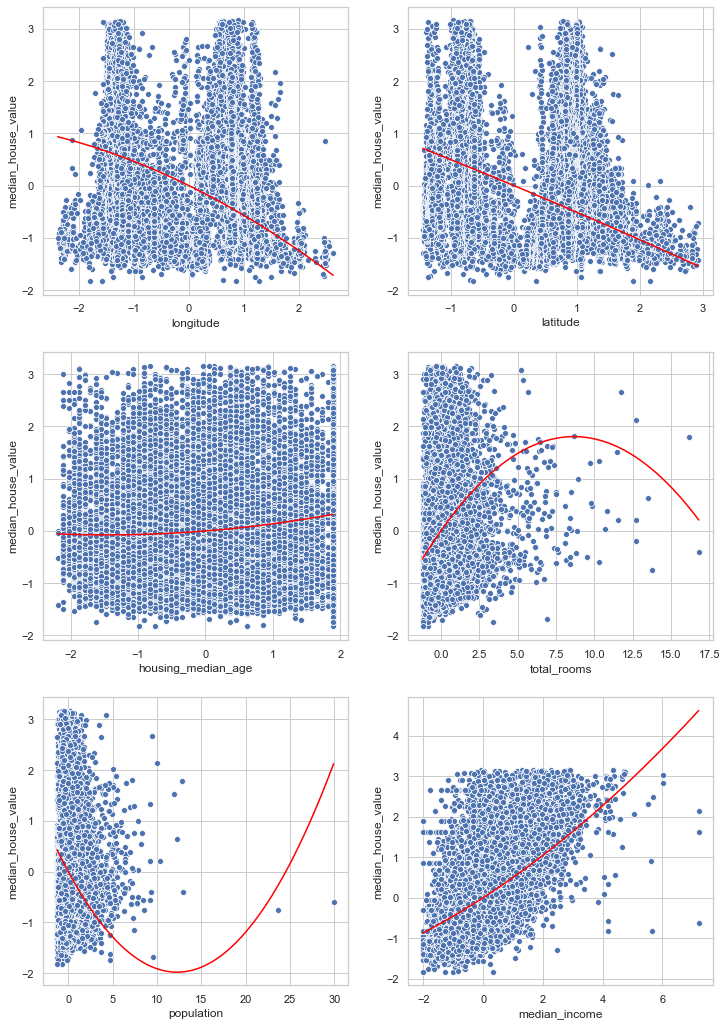

In [129]:
f, ((p1,p2), (p3,p4), (p5,p6)) = plt.subplots(nrows = 3, ncols = 2, figsize = (12,18))

sb.scatterplot(x = data['longitude'], y = y, ax = p1)
t = np.linspace(min(data.longitude.values), max(data.longitude.values), num = 1000)
p1.plot(t, w.longitude_x[0] * t + w.longitude_y[0] * t**2, color = 'red')

sb.scatterplot(x = data['latitude'], y = y, ax = p2)
t = np.linspace(min(data.latitude.values), max(data.latitude.values), num = 1000)
p2.plot(t, w.latitude_x[0] * t + w.latitude_y[0] * t**2, color = 'red')

sb.scatterplot(x = data['housing_median_age'], y = y, ax = p3)
t = np.linspace(min(data.housing_median_age.values), max(data.housing_median_age.values), num = 1000)
p3.plot(t, w.housing_median_age_x[0] * t + w.housing_median_age_y[0] * t**2, color = 'red')

sb.scatterplot(x = data['total_rooms'], y = y, ax = p4)
t = np.linspace(min(data.total_rooms.values), max(data.total_rooms.values), num = 1000)
p4.plot(t, w.total_rooms_x[0] * t + w.total_rooms_y[0] * t**2, color = 'red')

sb.scatterplot(x = data['population'], y = y, ax = p5)
t = np.linspace(min(data.population.values), max(data.population.values), num = 1000)
p5.plot(t, w.population_x[0] * t + w.population_y[0] * t**2, color = 'red')

sb.scatterplot(x = data['median_income'], y = y, ax = p6)
t = np.linspace(min(data.median_income.values), max(data.median_income.values), num = 1000)
p6.plot(t, w.median_income_x[0] * t + w.median_income_y[0] * t**2, color = 'red')

plt.show()

### 5. CONCLUSIONS

On the basis of the previous analysis, the purposes stated in Section 1 can now be checked and the actual results summarized. In particular, the questions of interest were:

- whether Ridge regression would improve stability and how it would affect accuracy;
- which strategies may help improve the results in the particular case of California housing data.

The answer to the first one was negative: little to no change in error variance across folds was observed when varying the regularization parameter $\alpha$. Moreover, both the average MSE on test folds and the average $R^{2}$ on training folds tended to get worse as $\alpha$ increased. A plausible explanation was outlined, mainly based on the low training accuracy: although, in principle, regularization should help avoid overfitting, the linear model may underfit, so a broader class of predictors may be needed.

In this task, Ridge regression is useless by itself, so 3 strategies were proposed:

- restricting the regression to 4 geographical subsets, in order to verify whether interaction terms ought to be included;
- applying dimension reduction techniques, such as FAMD and PCA;
- including quadratic terms in the model.

As for the first approach, Ridge regression yields similar results in 3 out of 4 areas, driving also the fourth towards the others when $\alpha$ is large enough ($\alpha > 100$ approximately), so the model may not be worth complicating.

Factor Analysis even worsened the results. In fact, when restricting the regression to the first 2 principal components, accuracy fell sharply, probably due to the fact that those dimensions didn't include the variable that had been identified as the major driver for house value, i.e. the median income within the neighborhood. 

The only strategy that produced slightly better results was the last one, with small increases in both training and test accuracy measures. Also for these terms, the regularization coefficient hasn't really stabilized the estimates, but the cross-validated MSE presented a diminishing variance. Also, all coefficients were found to be significant at a 5% level after a certain $\alpha$, thus suggesting that a non-linear model may perform better.